# Tendon Gliding Hand Action Recognition

# Description

- The goal is to perform Tendon Gliding Hand Action Recognition by classifying hand postures into five distinct classes using real-time video. Additionally, the task involves calculating the accuracy of hand skeleton occurrences compared to the ground truth.
- The classes are as follows: **Hand Open**, **Intrinsic Plan**, **Straight Fist**, **Hand Close**, and **Hook Hand**.  

<p align="center">
    <img src='../../IMAGES/Classes.jpg' width="500px" />
</p>

- The base workflow is as follows: 

<div align="center">

```mermaid
graph LR
    A[Import RAW Data]
    A --> B[Separate into 5 different classes]
    B --> C[Generate 2D keypoints of X and Y coordinates]
    C --> D[Train LSTM model]
    D --> E[Evaluate Performance]
    E --> F[Metrics: Accuracy, Specificity, Sensitivity, F1-Score, Confusion Matrix]
```

</div>

## 0. Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import rerun as rr
import rerun.blueprint as rrb
import seedir as sd
import os
import albumentations as A
from pyorbbecsdk import *
import cv2
from utils import frame_to_bgr_image
from pathlib import Path
import shutil
from collections import defaultdict

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"

## 1. Utility Function

In [2]:
def list_bag_files(root_dir='data'):
    """
    List all .bag files in the directory structure, excluding those in 'open-hand' folders.
    
    Args:
        root_dir (str): Root directory to start the search from.
        
    Returns:
        list: List of paths to .bag files.
    """
    bag_files = []
    
    for root, dirs, files in os.walk(root_dir):
        # Skip 'open-hand' directories
        if 'open-fist' in os.path.basename(root):
            continue
            
        # Add .bag files to the list
        for file in files:
            if file.endswith('.bag'):
                bag_files.append(os.path.join(root, file))
                
    return bag_files

def playback_state_callback(state):
    """Callback function to handle playback state transitions."""
    global playback_finished
    if state == OBMediaState.OB_MEDIA_BEGIN:
        print("Bag player begin")
    elif state == OBMediaState.OB_MEDIA_END:
        print("Bag player end")
        playback_finished = True  # Signal that playback has finished
    elif state == OBMediaState.OB_MEDIA_PAUSED:
        print("Bag player paused")

def process_frames(bag_file):
    """
    Process the .bag file and return lists of processed images.
    
    Returns:
        depth_image_list: List of raw depth data (converted to float and scaled).
        color_image_list: List of processed color images.
        overlaid_image_list: List of images with overlay (color blended with depth colormap).
    """
    global playback_finished
    playback_finished = False  # Reset flag

    pipeline = Pipeline(bag_file)
    playback = pipeline.get_playback()
    playback.set_playback_state_callback(playback_state_callback)

    # Start the pipeline
    pipeline.start()

    depth_image_list = []
    color_image_list = []

    while not playback_finished:
        frames = pipeline.wait_for_frames(100)
        if frames is None:
            if playback_finished:
                print("All frames have been processed and converted successfully.")
                break
            continue

        # Retrieve frames once per iteration
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()

        if depth_frame is not None:
            width = depth_frame.get_width()
            height = depth_frame.get_height()
            scale = depth_frame.get_depth_scale()

            # Process raw depth data
            depth_data = np.frombuffer(depth_frame.get_data(), dtype=np.uint16)
            depth_data = depth_data.reshape((height, width))
            depth_data = depth_data.astype(np.float32) * scale
            depth_image_list.append(depth_data)

            # Normalize and invert to obtain desired mapping (farthest = red, closest = blue)
            depth_norm = cv2.normalize(depth_data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            inverted_depth = 255 - depth_norm
            depth_image = cv2.applyColorMap(inverted_depth, cv2.COLORMAP_JET)
        else:
            depth_image = None

        if color_frame is not None:
            width = color_frame.get_width()
            height = color_frame.get_height()

            color_data = frame_to_bgr_image(color_frame)
            color_image = cv2.resize(color_data, (width, height))
            # Convert to BGR if necessary; adjust if frame_to_bgr_image already outputs BGR
            color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
            color_image_list.append(color_image)
        else:
            color_image = None

    return depth_image_list, color_image_list

def rerun_visualization(*image_lists):
    """
    Create a rerun visualization with multiple image lists displayed in a grid.
    
    Args:
        *image_lists: Variable number of image lists to display
    """
    stream = rr.new_recording("spawn", spawn=True)
    
    # Dynamically create spatial views for each image list
    spatial_views = []
    for i in range(len(image_lists)):
        spatial_views.append(rrb.Spatial2DView(origin=f'/color_image_{i}'))
    
    # Calculate a reasonable number of columns for the grid
    # You can adjust this logic based on your preference
    num_columns = min(3, len(image_lists))  # Max 3 columns
    
    # Setup the blueprint with dynamic grid configuration
    blueprint = rrb.Blueprint(
        rrb.Grid(*spatial_views, grid_columns=num_columns),
        collapse_panels=True
    )
    
    # Calculate the maximum length across all image lists
    max_length = max(len(image_list) for image_list in image_lists)
    
    # Log all images with proper time sequencing
    for idx in range(max_length):
        stream.set_time_sequence("frame", idx)
        
        # Log each image list at the current index if available
        for list_idx, image_list in enumerate(image_lists):
            if idx < len(image_list):
                stream.log(f"color_image_{list_idx}", rr.Image(image_list[idx]))
    
    stream.send_blueprint(blueprint)

def sliding_window_sample(images, window_size=16, stride=8):
    total_frames = len(images)
    windows = []
    
    for start_idx in range(0, total_frames - window_size + 1, stride):
        end_idx = start_idx + window_size
        window = np.stack(images[start_idx:end_idx])
        windows.append(window)
    
    return windows

def visualize_windows(windows):
    """
    Visualize multiple windows of image sequences in Rerun.
    
    Args:
        windows: List of image windows, where each window is a sequence of frames
        max_windows_to_display: Maximum number of windows to display in the grid
    """
    stream = rr.new_recording("spawn", spawn=True)
    
    # Limit the number of windows to display to avoid overcrowding
    num_windows = len(windows)
    
    # Create spatial views for each window
    spatial_views = []
    for i in range(num_windows):
        spatial_views.append(rrb.Spatial2DView(origin=f'/window_{i}'))
    
    # Calculate grid layout (max 3 columns)
    num_columns = min(3, num_windows)
    
    # Setup the blueprint with dynamic grid configuration
    blueprint = rrb.Blueprint(
        rrb.Grid(*spatial_views, grid_columns=num_columns),
        collapse_panels=True
    )
    
    # Log the frames of each window
    window_size = windows[0].shape[0]  # Get the size of each window
    
    # Log each frame in each window
    for frame_idx in range(window_size):
        stream.set_time_sequence("frame", frame_idx)
        
        # Log the current frame from each window
        for window_idx in range(num_windows):
            if window_idx < len(windows):
                stream.log(f"window_{window_idx}", 
                          rr.Image(windows[window_idx][frame_idx]))
    
    # Display info about the windows
    print(f"Visualizing {num_windows} windows out of {len(windows)} total")
    print(f"Each window contains {window_size} frames")
    print(f"Window shape: {windows[0].shape}")
    
    stream.send_blueprint(blueprint)

def save_windowed_data(recordings, bag_files, window_size=16, stride=8):
    """
    Save windowed data for RGB and depth images for each recording to its respective folder.
    
    Args:
        recordings: Dictionary containing recordings with color_images and depth_images
        bag_files: List of bag file paths sorted to match recording indices
        window_size: Size of each window
        stride: Stride between consecutive windows
    """
    print(f"Saving windowed data for {len(recordings)} recordings...")
    
    for recording_idx, bag_file_path in enumerate(bag_files):
        recording_key = f"recording_{recording_idx}"
        
        # Check if the recording exists
        if recording_key in recordings:
            recording_data = recordings[recording_key]
            # Create base output directory for this recording
            bag_path = Path(bag_file_path)
            base_output_dir = bag_path.parent / "windowed_data"
            
            # Process each image type (RGB and depth)
            image_types = {
                "color_images": "rgb",
                "depth_images": "depth"
            }
            
            for image_key, folder_name in image_types.items():
                if image_key in recording_data and recording_data[image_key] is not None:
                    images = recording_data[image_key]
                    
                    # Create windows for this image type
                    windows = sliding_window_sample(images, window_size=window_size, stride=stride)
                    
                    # Create output directory for this image type
                    output_dir = base_output_dir / folder_name
                    os.makedirs(output_dir, exist_ok=True)
                    
                    # Create a base filename from the bag file
                    base_filename = bag_path.stem
                    
                    # Save each window as a separate .npy file
                    for window_idx, window in enumerate(windows):
                        # Create filename: RecordXXX_window_NNN.npy
                        window_filename = f"{base_filename}_window_{window_idx:03d}.npy"
                        output_path = output_dir / window_filename
                        
                        # Save the window data
                        np.save(output_path, window)
                    
                    print(f"Saved {len(windows)} {folder_name} windows for {recording_key} to {output_dir}")
                else:
                    print(f"Skipping {image_key} for {recording_key}: Data not available")
        else:
            print(f"Skipping recording {recording_idx}: Recording not found")
    
    print("Windowed data saving complete!")

# Function to create all the recordings dictionary from processed_data
def prepare_recordings_dict(processed_data):
    recordings = {}
    for i in range(6):  # Assuming there are 6 recordings (0-5)
        recording_key = f"recording_{i}"
        if recording_key in processed_data:
            recordings[recording_key] = processed_data[recording_key]
    return recordings

## 2. Data Preparation

- In total there are six different recordings of tendon gliding task as follows: 
    - From 📁 `20250402`
        - `Record_20250402151124.bag`
        - `Record_20250402151609.bag`
        - `Record_20250402152331.bag`
    - From 📁 `20250506`
        - `Record_20250506145704.bag`
        - `Record_20250506152951.bag`
        - `Record_20250506162630.bag`
- Each data consist of RGB frames and Depth frames
- Workflow: 

<div align="center">

```mermaid
graph LR
    A[Data Extraction] --> B[Data Visualization]
    B --> C[Windowing Process]
    C --> D[Save Windowed Data]
    D --> E[Data Class Generation]
```

</div>

**Data Extraction**

In [3]:
bag_files = list_bag_files()
data_20250402 = bag_files[:3]      # First three items
data_20250506 = bag_files[-3:]     # Last three items
processed_data = {}

# Process the 20250402 files
for idx, bag_file in enumerate(data_20250402):
    print(f"Processing bag file: {bag_file}")
    # Process the frames in the bag file
    depth_images, color_images = process_frames(bag_file)
    # Store the lists in the dictionary with dataset identifier
    processed_data[f"recording_{idx}"] = {
        "dataset": "20250402",
        "depth_images": depth_images,
        "color_images": color_images
    }

# Process the 20250506 files
for idx, bag_file in enumerate(data_20250506):
    print(f"Processing bag file: {bag_file}")
    # Process the frames in the bag file
    depth_images, color_images = process_frames(bag_file)
    # Store the lists in the dictionary with dataset identifier
    processed_data[f"recording_{idx+3}"] = {  # Add offset to avoid key collision
        "dataset": "20250506",
        "depth_images": depth_images,
        "color_images": color_images
    }

Processing bag file: data\20250402\Record_20250402151124.bag
Bag player begin
Bag player end
Processing bag file: data\20250402\Record_20250402151609.bag
Bag player begin
Bag player end
Processing bag file: data\20250402\Record_20250402152331.bag
Bag player begin
Bag player end
Processing bag file: data\20250506\T2\tendon-gliding\Record_20250506145704.bag
Bag player begin
Bag player end
Processing bag file: data\20250506\T3\tendon-gliding\Record_20250506152951.bag
Bag player begin
Bag player end
Processing bag file: data\20250506\T4\tendon-gliding\Record_20250506162630.bag
Bag player begin
Bag player end


**Data Visualization**

In [51]:
recording_0 = processed_data.get("recording_0")
recording_1 = processed_data.get("recording_1")
recording_2 = processed_data.get("recording_2")
recording_3 = processed_data.get("recording_3")
recording_4 = processed_data.get("recording_4")
recording_5 = processed_data.get("recording_5")

image_lists = []
for recording_idx in range(6):  # Assuming you have 6 recordings
    recording_key = f"recording_{recording_idx}"
    if recording_key in processed_data and "color_images" in processed_data[recording_key]:
        image_lists.append(processed_data[recording_key]["color_images"])

# Visualize all valid image lists together
if image_lists:
    rerun_visualization(*image_lists)

**Windowing Process**

In [42]:
# Get the color images from recording_0
color_images = recording_0["color_images"]

# Get multiple windows of 16 frames each
rgb_windows = sliding_window_sample(color_images, window_size=16, stride=8)

# Visualize the windows
visualize_windows(rgb_windows)

Visualizing 12 windows out of 12 total
Each window contains 16 frames
Window shape: (16, 800, 1280, 3)


**Save Windowed Data into 📁 `rgb` and 📁 `depth`**

In [4]:
recordings = prepare_recordings_dict(processed_data)
save_windowed_data(recordings, bag_files)

Saving windowed data for 6 recordings...
Saved 12 rgb windows for recording_0 to data\20250402\windowed_data\rgb
Saved 12 depth windows for recording_0 to data\20250402\windowed_data\depth
Saved 10 rgb windows for recording_1 to data\20250402\windowed_data\rgb
Saved 10 depth windows for recording_1 to data\20250402\windowed_data\depth
Saved 13 rgb windows for recording_2 to data\20250402\windowed_data\rgb
Saved 13 depth windows for recording_2 to data\20250402\windowed_data\depth
Saved 38 rgb windows for recording_3 to data\20250506\T2\tendon-gliding\windowed_data\rgb
Saved 38 depth windows for recording_3 to data\20250506\T2\tendon-gliding\windowed_data\depth
Saved 29 rgb windows for recording_4 to data\20250506\T3\tendon-gliding\windowed_data\rgb
Saved 29 depth windows for recording_4 to data\20250506\T3\tendon-gliding\windowed_data\depth
Saved 22 rgb windows for recording_5 to data\20250506\T4\tendon-gliding\windowed_data\rgb
Saved 22 depth windows for recording_5 to data\20250506\T

**Data Class Generation**

There are 5 class to be pick up from the windowed data: `Hand Open (HO)`, `Intrinsic Hand (IH)`, `Straight Fist (SF)`, `Hand Close (HC)`, and `Hook Hand (HH)`.

In [5]:
def create_dataset(recordings, bag_files, class_info_dict, output_dir="video", max_samples_per_recording=2):
    """
    Create a balanced dataset with RGB and depth samples for each class from each recording.
    
    Args:
        recordings: Dictionary containing recordings with processed data
        bag_files: List of bag file paths
        class_info_dict: Dictionary mapping recording names to class window indices
        output_dir: Output directory name
        max_samples_per_recording: Maximum number of samples to include per class per recording
    """
    # Define class acronyms and their full names
    class_acronyms = ["OH", "IH", "SF", "HC", "HH"]
    class_full_names = {
        "OH": "Open Hand",
        "IH": "Intrinsic Hand",
        "SF": "Straight Fist",
        "HC": "Hand Close",
        "HH": "Hook Hand"
    }
    
    # Define modalities
    modalities = ["rgb", "depth"]
    
    # Create main output directory
    output_path = Path(output_dir)
    
    # Create class and modality folders
    for acronym in class_acronyms:
        for modality in modalities:
            class_modality_folder = output_path / modality / acronym
            os.makedirs(class_modality_folder, exist_ok=True)
    
    # Track which samples we've collected for each class
    collected_samples = defaultdict(list)
    
    # Process each recording
    for recording_idx, bag_file_path in enumerate(bag_files):
        bag_path = Path(bag_file_path)
        recording_name = bag_path.stem
        recording_key = f"recording_{recording_idx}"
        
        # Skip if recording doesn't exist in our data
        if recording_key not in recordings:
            print(f"Warning: {recording_key} not found in recordings, skipping...")
            continue
        
        # Skip if recording doesn't have class information
        if recording_name not in class_info_dict:
            print(f"Warning: No class information for {recording_name}, skipping...")
            continue
        
        # Get class information for this recording
        recording_class_info = class_info_dict[recording_name]
        
        # Process each class in this recording
        for acronym in class_acronyms:
            # Get available window indices for this class
            window_indices = recording_class_info.get(acronym, [])
            
            # Limit to the maximum number of samples per recording
            selected_indices = window_indices[:max_samples_per_recording]
            
            # For each selected window index
            for window_idx in selected_indices:
                # Process each modality (rgb and depth)
                for modality in modalities:
                    # Get windowed data directory for this recording and modality
                    windowed_data_dir = bag_path.parent / "windowed_data" / modality
                    
                    # Build the source filename
                    window_filename = f"{recording_name}_window_{window_idx:03d}.npy"
                    source_path = windowed_data_dir / window_filename
                    
                    # Skip if source file doesn't exist
                    if not source_path.exists():
                        print(f"Warning: {modality} file {source_path} not found, skipping...")
                        continue
                    
                    # Create destination filename
                    dest_filename = f"{recording_name}_w{window_idx:03d}.npy"
                    dest_path = output_path / modality / acronym / dest_filename
                    
                    # Copy the file
                    shutil.copy2(source_path, dest_path)
                
                # Track which samples we've collected (only track once per sample, not per modality)
                collected_samples[acronym].append((recording_name, window_idx))
                
                print(f"Copied {class_full_names[acronym]} ({acronym}) sample from {recording_name}, window {window_idx} (both rgb and depth)")
    
    # Check if we have enough samples for each class (12 samples per class)
    target_count = len(bag_files) * max_samples_per_recording
    for acronym in class_acronyms:
        samples_count = len(collected_samples[acronym])
        
        print(f"Class {class_full_names[acronym]} ({acronym}): {samples_count}/{target_count} samples collected")
        
        # If we don't have enough samples, try to get more from recordings with extra samples
        if samples_count < target_count:
            additional_needed = target_count - samples_count
            print(f"Need {additional_needed} more samples for {acronym}")
            
            # Find all available samples for this class across all recordings
            all_available = []
            for recording_idx, bag_file_path in enumerate(bag_files):
                bag_path = Path(bag_file_path)
                recording_name = bag_path.stem
                
                if recording_name in class_info_dict and acronym in class_info_dict[recording_name]:
                    # Get indices that haven't been used yet
                    used_indices = [idx for name, idx in collected_samples[acronym] if name == recording_name]
                    available_indices = [idx for idx in class_info_dict[recording_name][acronym] if idx not in used_indices]
                    
                    for idx in available_indices:
                        all_available.append((recording_name, idx))
            
            # Use extra samples to fill in
            for i, (recording_name, window_idx) in enumerate(all_available):
                if i >= additional_needed:
                    break
                    
                # Find the bag file path for this recording
                recording_bag_path = None
                for bag_file_path in bag_files:
                    if Path(bag_file_path).stem == recording_name:
                        recording_bag_path = Path(bag_file_path)
                        break
                
                if recording_bag_path is None:
                    continue
                
                # Process each modality for this additional sample
                for modality in modalities:
                    # Get the source path
                    windowed_data_dir = recording_bag_path.parent / "windowed_data" / modality
                    window_filename = f"{recording_name}_window_{window_idx:03d}.npy"
                    source_path = windowed_data_dir / window_filename
                    
                    # Skip if source file doesn't exist
                    if not source_path.exists():
                        print(f"Warning: Additional {modality} file {source_path} not found, skipping...")
                        continue
                        
                    # Create destination filename
                    dest_filename = f"{recording_name}_w{window_idx:03d}.npy"
                    dest_path = output_path / modality / acronym / dest_filename
                    
                    # Copy the file
                    shutil.copy2(source_path, dest_path)
                
                # Track which samples we've collected (only once per sample)
                collected_samples[acronym].append((recording_name, window_idx))
                
                print(f"Added extra {class_full_names[acronym]} ({acronym}) sample from {recording_name}, window {window_idx} (both rgb and depth)")
    
    # Final count and validation
    for acronym in class_acronyms:
        rgb_count = len(list((output_path / "rgb" / acronym).glob("*.npy")))
        depth_count = len(list((output_path / "depth" / acronym).glob("*.npy")))
        
        print(f"Final count for {class_full_names[acronym]} ({acronym}):")
        print(f"  - RGB: {rgb_count} samples")
        print(f"  - Depth: {depth_count} samples")
        
        # Check if counts match
        if rgb_count != depth_count:
            print(f"  - WARNING: RGB and depth counts don't match for {acronym}!")

# Use the provided dictionary directly
info_dict = {
    "Record_20250402151124": {
        "OH": [0, 10, 11],
        "IH": [1, 2],
        "SF": [3, 4],
        "HC": [5, 6],
        "HH": [7, 8]
    },
    "Record_20250402151609": {
        "OH": [0, 9],
        "IH": [1, 2],
        "SF": [3, 4],
        "HC": [5],
        "HH": [6, 7]
    },
    "Record_20250402152331": {
        "OH": [0, 1, 2, 12],
        "IH": [3, 4],
        "SF": [5, 6],
        "HC": [7],
        "HH": [8, 9]
    },
    "Record_20250506145704": {
        "OH": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        "IH": [11, 12, 13, 14, 15],
        "SF": [16, 17, 18, 19, 20, 21],
        "HC": [22, 23, 24, 25, 26],
        "HH": [27, 28, 29, 30, 31]
    },
    "Record_20250506152951": {
        "OH": [0, 1, 2, 3, 4],
        "IH": [5, 6, 7, 8],
        "SF": [10, 11, 12, 13],
        "HC": [14, 15, 16, 17],
        "HH": [18, 19, 20, 21]
    },
    "Record_20250506162630": {
        "OH": [0, 1, 2, 3, 4, 5],
        "IH": [6, 7],
        "SF": [8],
        "HC": [9, 10, 11, 12],
        "HH": [13, 14]
    }
}

# Create the dataset
create_dataset(processed_data, bag_files, info_dict, output_dir=r"./data/video")

Copied Open Hand (OH) sample from Record_20250402151124, window 0 (both rgb and depth)
Copied Open Hand (OH) sample from Record_20250402151124, window 10 (both rgb and depth)
Copied Intrinsic Hand (IH) sample from Record_20250402151124, window 1 (both rgb and depth)
Copied Intrinsic Hand (IH) sample from Record_20250402151124, window 2 (both rgb and depth)
Copied Straight Fist (SF) sample from Record_20250402151124, window 3 (both rgb and depth)
Copied Straight Fist (SF) sample from Record_20250402151124, window 4 (both rgb and depth)
Copied Hand Close (HC) sample from Record_20250402151124, window 5 (both rgb and depth)
Copied Hand Close (HC) sample from Record_20250402151124, window 6 (both rgb and depth)
Copied Hook Hand (HH) sample from Record_20250402151124, window 7 (both rgb and depth)
Copied Hook Hand (HH) sample from Record_20250402151124, window 8 (both rgb and depth)
Copied Open Hand (OH) sample from Record_20250402151609, window 0 (both rgb and depth)
Copied Open Hand (OH) 

## 3. Model Development

**Create Dataset Object**

In [6]:
import os
import glob
import numpy as np
from datasets import Dataset, Features, Value, ClassLabel

# 1. Create lists of file paths and labels
image_rgb_dir = r'./data/video/rgb'
filepaths, labels = [], []
for class_name in os.listdir(image_rgb_dir):
    class_dir = os.path.join(image_rgb_dir, class_name)
    for npy_path in glob.glob(os.path.join(class_dir, '*.npy')):
        filepaths.append(npy_path)
        labels.append(class_name)

# 2. Create dataset with file paths
unique_labels = sorted(set(labels))
pr_ds = Dataset.from_dict({
    "image_path": filepaths,
    "label": labels
})

# 3. Encode the label column
pr_ds = pr_ds.class_encode_column("label")

# 4. Create a function to load images when needed
def load_image(example):
    example["image"] = np.load(example["image_path"])
    return example

# 5. Split the dataset
split1 = pr_ds.train_test_split(test_size=0.25, shuffle=True, seed=42, stratify_by_column="label")
train_ds = split1["train"]
val_ds = split1["test"]

# 6. Build label2id / id2label
label2id = {lab: idx for idx, lab in enumerate(unique_labels)}
id2label = {idx: lab for lab, idx in label2id.items()}

Casting to class labels:   0%|          | 0/60 [00:00<?, ? examples/s]

**Model Initialization**

In [8]:
from transformers import VideoMAEForVideoClassification, AutoImageProcessor
from torchinfo import summary
import torch

model_ckpt = 'MCG-NJU/videomae-base'
sw_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)
sw_model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id, 
)

print(sw_model.config)

print(summary(sw_model,
        input_size=(1, 16, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params"],
        row_settings=["depth"],
        device='cpu'))

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VideoMAEConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "VideoMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "HC",
    "1": "HH",
    "2": "IH",
    "3": "OH",
    "4": "SF"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "HC": 0,
    "HH": 1,
    "IH": 2,
    "OH": 3,
    "SF": 4
  },
  "layer_norm_eps": 1e-12,
  "model_type": "videomae",
  "norm_pix_loss": true,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 16,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "tubelet_size": 2,
  "use_mean_pooling": false
}

Layer (type:depth-idx)                      

**Set Up Transformation Pipeline**

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
import torchvision.transforms.functional as tvf
import einops

class Normalize(nn.Module):
    """
    Normalize a (T, C, H, W) tensor by per-channel mean/std,
    treating T as the batch dimension.
    """
    def __init__(self,
                 mean: Tuple[float, float, float],
                 std:  Tuple[float, float, float],
                 inplace: bool = False):
        super().__init__()
        self.mean    = mean
        self.std     = std
        self.inplace = inplace

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is (T, C, H, W); tvf.normalize expects (N, C, H, W)
        return tvf.normalize(x, self.mean, self.std, self.inplace)
    
mean = sw_processor.image_mean
std = sw_processor.image_std
num_frames_to_samples = sw_model.config.num_frames
height = sw_processor.size.get("shortest_edge", sw_processor.size.get("height"))
width = height
resize_to = (height, width)

from torchvision.transforms import Compose, Lambda, RandomCrop, RandomHorizontalFlip

transformation_pipeline = Compose([
    Lambda(lambda x: x / 255.0),                          # now x is float [0,1]
    Normalize(mean, std),                                 # per‑channel norm
    Lambda(lambda x: F.interpolate(                             
        x, size=resize_to, mode="bilinear", align_corners=False 
    )),                                                          # resize to (H,W) = resize_to
])


**Apply Transformation Pipeline to Dataset**

In [11]:
def preprocess_train(batch):
    pixel_values = []
    for path in batch["image_path"]:
        # Load the numpy array from file - shape (T, H, W, C) = (16, 800, 1280, 3)
        arr = np.load(path)
        
        # Convert numpy array to tensor
        vid = torch.as_tensor(arr, dtype=torch.float32)
        
        # Rearrange from (T, H, W, C) to (T, C, H, W) using einops
        vid = einops.rearrange(vid, 't h w c -> t c h w')
        
        # Apply transformations
        vid_t = transformation_pipeline(vid)
        pixel_values.append(vid_t)
    
    batch["pixel_values"] = pixel_values
    batch["labels"] = batch["label"]
    return batch

def preprocess_val(batch):
    pixel_values = []
    for path in batch["image_path"]:
        # Load the numpy array from file - shape (T, H, W, C) = (16, 800, 1280, 3)
        arr = np.load(path)
        
        # Convert numpy array to tensor
        vid = torch.as_tensor(arr, dtype=torch.float32)
        
        # Rearrange from (T, H, W, C) to (T, C, H, W) using einops
        vid = einops.rearrange(vid, 't h w c -> t c h w')
        
        # Apply transformations
        vid_t = transformation_pipeline(vid)
        pixel_values.append(vid_t)
    
    batch["pixel_values"] = pixel_values
    batch["labels"] = batch["label"]
    return batch

# Apply preprocessing to training dataset
train_ds = train_ds.map(
    preprocess_train, 
    batched=True, 
    batch_size=4,
    remove_columns=["image_path", "label"]
)
train_ds.set_format(type="torch", columns=["pixel_values", "labels"])

# Apply preprocessing to validation dataset
val_ds = val_ds.map(
    preprocess_val, 
    batched=True, 
    batch_size=4,
    remove_columns=["image_path", "label"]
)
val_ds.set_format(type="torch", columns=["pixel_values", "labels"])

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

## 4. Model Fine-Tuning

**Setup `TrainingArguments`, `Trainer`, and `evaluate`**

In [13]:
from transformers import Trainer, TrainerCallback, TrainingArguments
import evaluate
from datetime import datetime
import pickle
import copy

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-without-aug"
num_train_epochs = 50
EXPERIMENT_DATE = datetime.now().strftime("%Y%m%d")
SAVE_DIR = f"experiments/video/{EXPERIMENT_DATE}/{new_model_name}"
batch_size = 8

args_pr = TrainingArguments(
    output_dir=SAVE_DIR,
    remove_unused_columns=False, 
    eval_strategy="epoch",
    save_strategy="best",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

accuracy  = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall    = evaluate.load("recall")
f1        = evaluate.load("f1")
confusion = evaluate.load("confusion_matrix")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # scalar metrics as before…
    acc   = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    prec  = precision.compute(predictions=preds, references=labels, average="macro")["precision"]
    rec   = recall.compute(predictions=preds, references=labels, average="macro")["recall"]
    f1sc  = f1.compute(predictions=preds, references=labels, average="macro")["f1"]

    # get confusion matrix and turn it into a nested Python list
    cm = confusion.compute(predictions=preds, references=labels)["confusion_matrix"]
    cm_list = cm.tolist()

    return {
        "accuracy":          acc,
        "precision":         prec,
        "recall":            rec,
        "f1":                f1sc,
        "confusion_matrix":  cm_list,    # now JSON‑serializable
    }

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # these will accumulate _all_ batches in the current epoch
        self.epoch_losses     = []
        self.epoch_preds      = []
        self.epoch_labels     = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Overrides Trainer.compute_loss to store batch‐level loss & preds/labels.
        """
        labels = inputs.get("labels", None)
        outputs = model(**inputs)
        loss   = outputs.loss
        logits = outputs.logits

        if labels is not None:
            # 1) store the loss
            self.epoch_losses.append(loss.item())
            # 2) store predictions + labels as 1D arrays
            preds = logits.argmax(dim=-1).detach().cpu().numpy()
            labs  = labels.detach().cpu().numpy()
            self.epoch_preds .extend(preds.tolist())
            self.epoch_labels.extend(labs.tolist())

        return (loss, outputs) if return_outputs else loss

class MetricsCallback(TrainerCallback):
    def __init__(self, trainer):
        super().__init__()
        self.trainer = trainer

        # lists to hold epoch‐by‐epoch values
        self.train_losses     = []
        self.train_accuracies = []
        self.eval_losses      = []
        self.eval_accuracies  = []
        self.eval_confusion_matrices = [] 

    def on_epoch_end(self, args, state, control, **kwargs):
        # Compute average training loss & accuracy for the epoch
        t = self.trainer
        avg_loss = float(np.mean(t.epoch_losses))
        acc      = np.mean(
            np.array(t.epoch_preds) == np.array(t.epoch_labels)
        )

        # Store & clear for next epoch
        self.train_losses    .append(avg_loss)
        self.train_accuracies.append(acc)
        t.epoch_losses .clear()
        t.epoch_preds  .clear()
        t.epoch_labels .clear()

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # metrics come prefixed with "eval_"
        self.eval_losses   .append(metrics["eval_loss"])
        self.eval_accuracies.append(metrics["eval_accuracy"])
        self.eval_confusion_matrices.append(metrics["eval_confusion_matrix"])

trainer = CustomTrainer(
    model=copy.deepcopy(sw_model),                 
    args=args_pr,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=sw_processor,          
    compute_metrics=compute_metrics, 
)

metrics_cb = MetricsCallback(trainer)
trainer.add_callback(metrics_cb)

C:\Users\11208120\AppData\Local\Temp\ipykernel_23124\3526279833.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


**Training**

In [ ]:
train_results = trainer.train()

**Training, Validation History Saving**

In [ ]:
history_val_ds = {
    "train_loss":     metrics_cb.train_losses,
    "train_accuracy": metrics_cb.train_accuracies,
    "eval_loss":      metrics_cb.eval_losses,
    "eval_accuracy":  metrics_cb.eval_accuracies,
    "eval_confusion_matrix": metrics_cb.eval_confusion_matrices,
}
history_train_val_ds_path = os.path.join(SAVE_DIR, "history_trainval.pkl")
with open(history_train_val_ds_path, "wb") as f:
    pickle.dump(history_val_ds, f)

**Plotting**

Visualizing: history_trainval.pkl


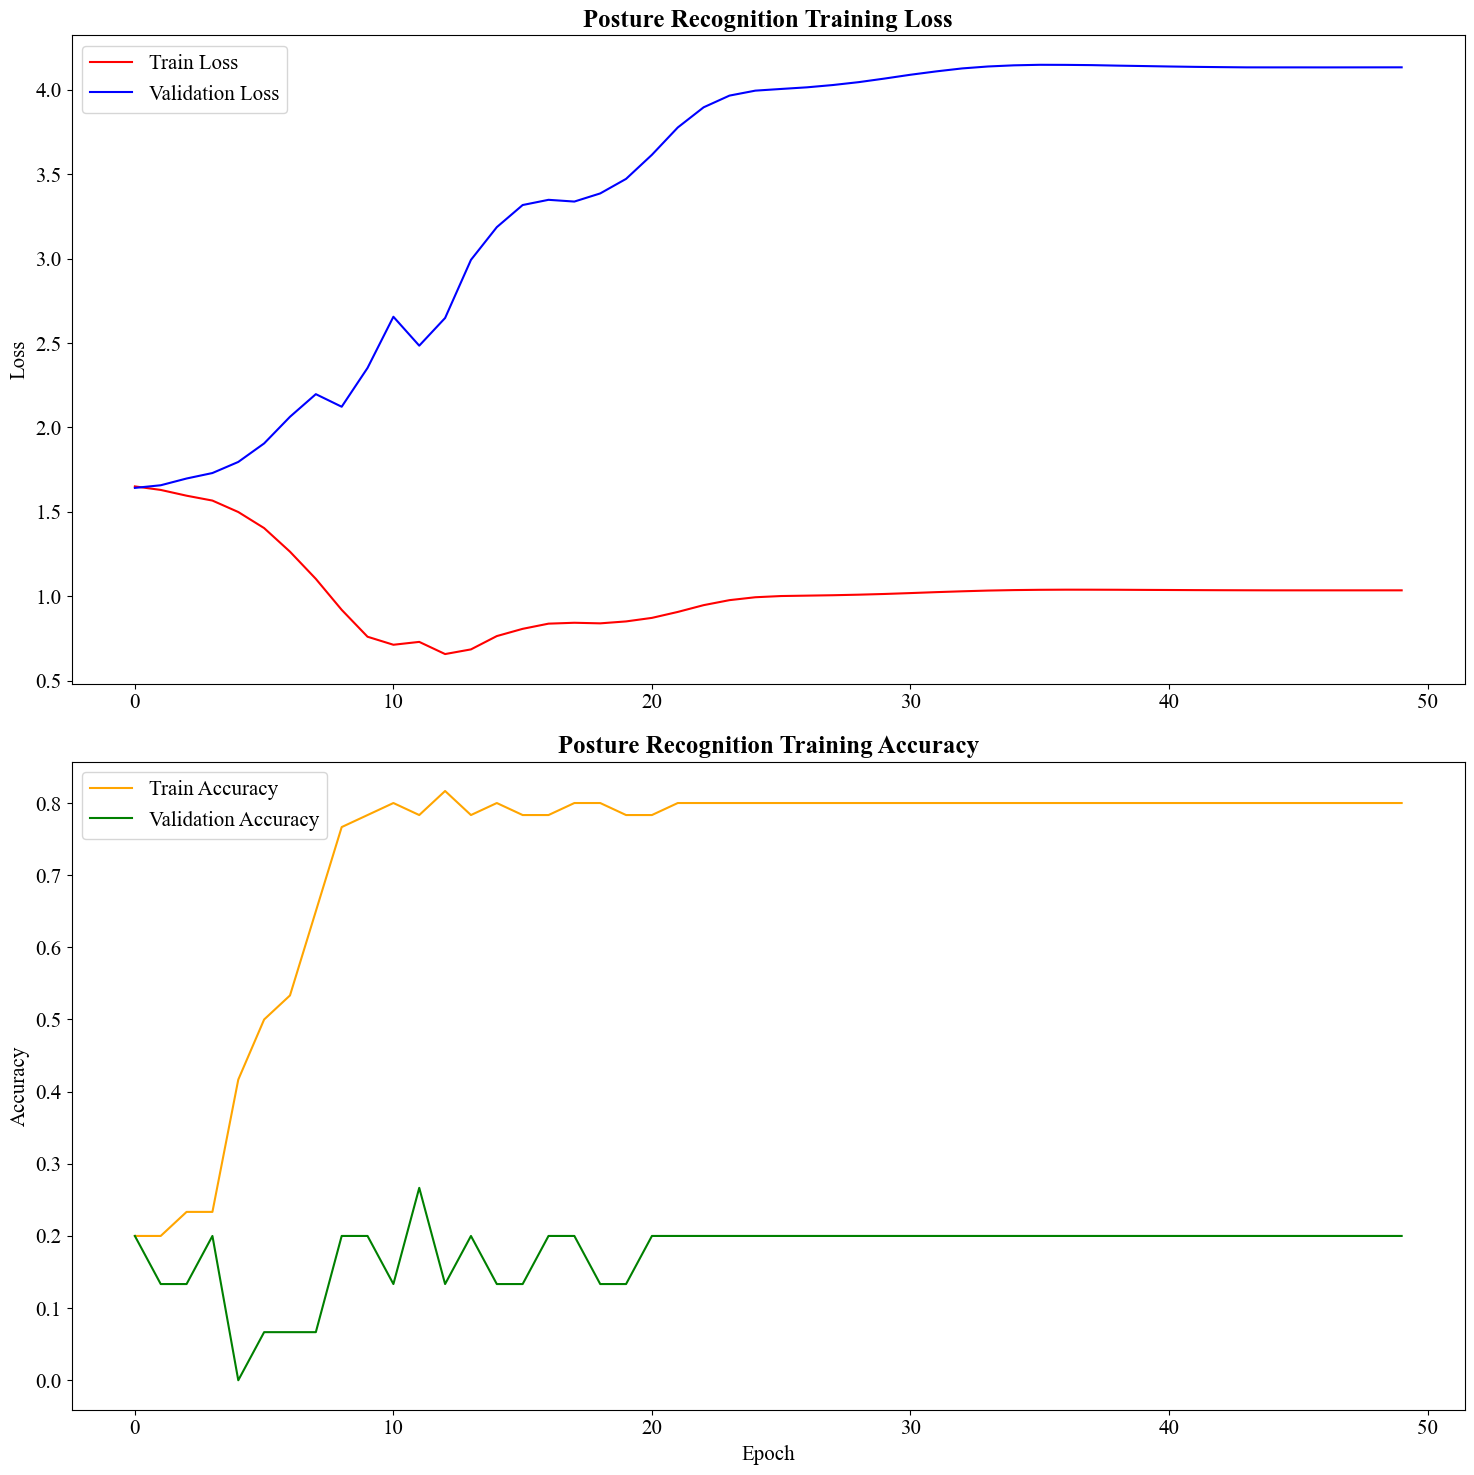

[INFO] Loading confusion matrix from: D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\experiments\video\20250514\videomae-base-finetuned-no-crop-no-aug\history_trainval.pkl


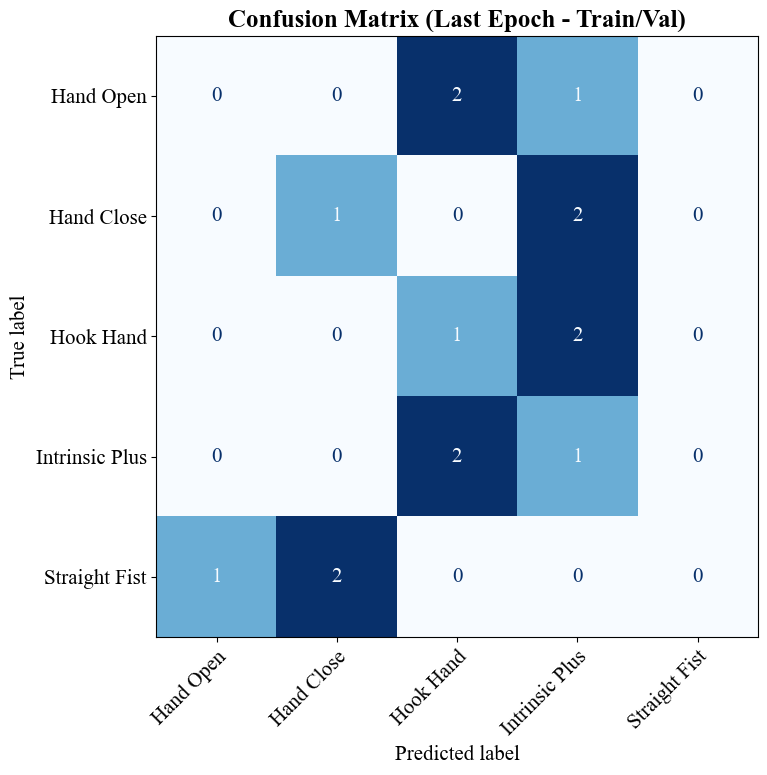

In [15]:
def visualize_train_val_losses(save_dir: str) -> None:
    import pickle
    import matplotlib.pyplot as plt
    import glob
    import os

    # Set global font properties
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 15

    # Search for history pickle files
    history_files = glob.glob(os.path.join(save_dir, "*.pkl"))

    for history_path in history_files:
        filename = os.path.basename(history_path)

        if "trainval" not in filename:
            continue  # skip non-trainval files

        print(f"Visualizing: {filename}")
        with open(history_path, "rb") as f:
            hist = pickle.load(f)

        fig, axs = plt.subplots(2, 1, figsize=(15, 15))

        # Plot loss
        axs[0].plot(hist["train_loss"], label="Train Loss", color='red')
        axs[0].plot(hist["eval_loss"], label="Validation Loss", color='blue')
        axs[0].set_title('Posture Recognition Training Loss', fontweight='bold')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        # Plot accuracy
        axs[1].plot(hist["train_accuracy"], label="Train Accuracy", color='orange')
        axs[1].plot(hist["eval_accuracy"], label="Validation Accuracy", color='green')
        axs[1].set_title('Posture Recognition Training Accuracy', fontweight='bold')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

def visualize_confusion_matrix(save_dir: str, mode: str = "trainval") -> None:
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay
    import glob
    import os

    # Look for the correct .pkl file based on mode
    history_files = glob.glob(os.path.join(save_dir, "*.pkl"))
    matched_file = None

    for file in history_files:
        if mode.lower() in os.path.basename(file).lower():
            matched_file = file
            break

    if not matched_file:
        print(f"[ERROR] No history file found in '{save_dir}' for mode '{mode}'")
        return

    print(f"[INFO] Loading confusion matrix from: {matched_file}")
    with open(matched_file, "rb") as f:
        hist = pickle.load(f)

    # Decide whether to use the last epoch or a single matrix
    if mode == "trainval":
        cm_data = hist["eval_confusion_matrix"][-1]
        title = "Confusion Matrix (Last Epoch - Train/Val)"
    else:
        cm_data = hist["eval_confusion_matrix"]
        title = f"Confusion Matrix ({mode.capitalize()})"

    cm = np.array(cm_data)
    class_names = [
        "Hand Open",
        "Hand Close",
        "Hook Hand",
        "Intrinsic Plus",
        "Straight Fist"
    ]

    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(title, fontweight="bold")

    plt.tight_layout()
    plt.show()

visualize_train_val_losses(r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\experiments\video\20250514\videomae-base-finetuned-no-crop-no-aug')
visualize_confusion_matrix(r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\experiments\video\20250514\videomae-base-finetuned-no-crop-no-aug', mode="trainval")